<a href="https://colab.research.google.com/github/ramprasad-nnr/Sentiment_On_Stock/blob/main/Demo_Project_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Demo Project Main file DA-232 Project 

**Project Details:**
**Decoding the Sentiment driven Stock market**


*abhishekk2@@iisc.ac.in, animeshs, sharpreet, ramprasadnnr @iisc.ac.in* 

---

**Description**
Analyse the stock market data, the financial news headlines over
a period of time in an attempt to identify stocks that generally tend to peak or dip together.

Another objective of the project is to identify stocks that are more sensitive to the financial
news sentiment, and show more volatility based on the news sentiment.

# Basic Setup

**Environment Setup**

In [1]:
#Step 1: Tool Chain Installation
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Add Check for .tgz file present
!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar xf /content/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install -q wordcloud

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

Mounted at /content/drive


In [2]:
#Step 2: Imports

#Spark
import findspark
findspark.init()
findspark.find()
from pyspark.sql.types import *
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import *
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import dayofweek
from pyspark.sql.functions  import year
from pyspark.sql.functions  import month
from pyspark.sql.functions import to_date

#nltk
import wordcloud
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Generic Imports
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
#Step 3: Creating Enviroment 

#PySpark
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .config('spark.sql.broadcastTimeout', '36000')\
         .getOrCreate()
##https://databricks.com/session_na20/on-improving-broadcast-joins-in-apache-spark-sql
##https://spark.apache.org/docs/latest/sql-performance-tuning.html


#nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Core & Utility Functionalities

In [4]:
#Global Paramaters

#DataSets
dataset_path = "/content/drive/MyDrive/DA_232_Project/DataSet/"
stock_dataset_path = dataset_path+"Stock/*.csv"
news_dataset_path = dataset_path+"IndianFinancialNews.csv"

#Time Lines
time_frame = 2022

#Window Sizes in days
window_size = [3, 7, 15, 30]

#Removing Variations of Stocks
valid_p_delta_range = 75

#HyperParameter - Weight for Title vs Description
w_title = 1

In [5]:
#Generic/Utility Functions

In [6]:
#Core Functions

#load_and_clean_stock_data:
#
#Arg: Dataset Path
#Ret: Stock DataSet
def load_and_clean_stock_data(path):
  df = spark.read.option("header",True).option("inferSchema",True).csv(path).dropDuplicates()
  df = df.withColumn("Date", col('Date').cast("timestamp"))
  print("Stock DateSet ", df.count())
  #df.show(5)
  return df

def load_and_clean_news_data(path):
  df = spark.read.option("header",True).option("inferSchema",True).csv(path)
  print("News DateSet ", df.count())
  
  #df.show(5)
  return df

exec_time = ""
#find_exec_time:
#
#Arg: Spark Df
#Ret: Stock DataSet
def find_exec_time(begin):
  global exec_time
  if begin:
    exec_time = datetime.now()
  else:
    print("Execution Time .....",(datetime.now() - exec_time).total_seconds()*1000,"msec")
    exec_time = ""

#CFIDF Algo ?
#Stop Words/Stem Words
def news_sentiment(news):
  sid = SentimentIntensityAnalyzer()
  score = sid.polarity_scores(news)['compound']
  if news:
    score = sid.polarity_scores(news)['compound']
    return score
  else:
    return 0  

spark.udf.register("NewsSentiments", news_sentiment)

def news_format_date(news_date):
    month_map = {
    "January":"01",
    "February":"02",
    "March":"03",
    "April":"04",
    "May":"05",
    "June":"06",
    "July":"07",
    "August":"08",
    "September":"09",
    "October":"10",
    "November":"11",
    "December":"12"
    }
    #return "1970-01-01"
    if news_date:
      day = news_date.split(",")[0].split()
      date = day[1].strip()
      month = month_map[day[0].strip()]
      year = news_date.split(",")[1].strip()

      date_full = year+"-"+month+"-"+date

      return date_full

    return "1970-01-01"


spark.udf.register("NewsFormatDate", news_format_date)


<function __main__.news_format_date>


print(delta_stock_df.filter((col("P_Delta") > 80) | (col("P_Delta") < -80)).count())

 +-----------------+------------------+
 |     max(P_Delta)|      min(P_Delta)|
 +-----------------+------------------+
 |62.68776737752903|-70.52554208011759|
 +-----------------+------------------+

# Core Logic - Data Manupulation

In [7]:
#Main Loading of Data 
find_exec_time(begin=True)
stock_df = load_and_clean_stock_data(stock_dataset_path)
find_exec_time(begin=False)
find_exec_time(begin=True)
news_df = load_and_clean_news_data("/content/drive/Shareddrives/DE-Sem1-Project/data/IndianFinancialNews.csv")
find_exec_time(begin=False)
stock_df = stock_df.filter(F.year(col("Date")) <= time_frame)
print("Stock Data After Filter", stock_df.count())


Stock DateSet  279906
Execution Time ..... 40641.603 msec
News DateSet  50000
Execution Time ..... 2038.5900000000001 msec
Stock Data After Filter 273331


In [8]:
#### NEWS DATA MANIPULATION
find_exec_time(begin=True)

news_udf = udf(news_sentiment, DoubleType())
fn = news_df.select("*", news_udf("Title").alias('Title_Sent'))
fn = fn.groupby('Date').avg('Title_Sent').withColumnRenamed('avg(Title_Sent)','News_Sentiment')

news_date_udf = udf(news_format_date, StringType())

fn = fn.select("*", news_date_udf("Date").alias('DateNews')).withColumn("DateNews", col('DateNews').cast("timestamp")).drop("Date")

#print(fn.rdd.filter(lambda x: (str(x).sta != -1)).collect())
fn = fn.filter(F.year(col("DateNews")) <= time_frame)
print("News Data After Filter", fn.count())
news_sentiment_df = fn.cache()
find_exec_time(begin=False)


News Data After Filter 6068
Execution Time ..... 4271.621 msec


In [9]:
#### STOCKS DATA MANIPULATION

## P_Delta = -80% < (Prev Close - Open) < +80%
##
delta_stock_df = stock_df.select("Date", "Symbol", ((col('Close') - col("Prev Close"))*100/col('Close')).alias("P_Delta")).\
                          filter((col("P_Delta") <= valid_p_delta_range) & (col("P_Delta") >= (-1*valid_p_delta_range)))
print("Valid Range Stock Data", delta_stock_df.count())

org_delta_stock_df = delta_stock_df

#A_P_Delta_<Days> = Average(P_Delta, Window(days), Symbol)
for d in window_size:
  w = (Window()
      .partitionBy(col("Symbol"))
      .orderBy(F.col("Date").cast('long'))
      .rowsBetween(-d, 0))
  delta_stock_df = delta_stock_df.withColumn('A_P_Delta_'+str(d), F.avg('P_Delta').over(w))

#A_M_P_Delta = Average(P_Delta) 
delta_stock_df_avg = delta_stock_df.groupBy("Date").\
                                    agg(F.mean(col('P_Delta')).alias("A_M_P_Delta")).\
                                    select(col("Date").alias("Date_avg"), "A_M_P_Delta")


##A_M_P_Delta_<Days> = Average(A_M_P_Delta, Window(days)) 
for d in window_size:
  w = (Window()
      .orderBy(F.col("Date_avg").cast('long'))
      .rowsBetween(-d, 0))
  delta_stock_df_avg = delta_stock_df_avg.withColumn('A_M_P_Delta_'+str(d), F.avg('A_M_P_Delta').over(w))


############
########### JOINING Average 
############

##P_OWN_Delta = COL(P_Delta - A_M_P_Delta)
delta_stock_df = delta_stock_df.join(delta_stock_df_avg, delta_stock_df.Date == delta_stock_df_avg.Date_avg).drop("Date_avg")

delta_stock_df = delta_stock_df.withColumn("P_OWN_Delta", (col("P_Delta")-col("A_M_P_Delta"))).drop("P_Delta").drop("A_M_P_Delta")


for d in window_size:
  delta_stock_df = delta_stock_df.withColumn("P_OWN_Delta_"+str(d), (col("A_P_Delta_"+str(d))-col("A_M_P_Delta_"+str(d)))).\
                                  drop("A_P_Delta_"+str(d)).drop("A_M_P_Delta_"+str(d))
  

p_own_delta = delta_stock_df

Valid Range Stock Data 273230


In [10]:
#### STOCKS AND NEWS Correlation

####HOLIDAY ..... ????

stock_news_df = org_delta_stock_df.join(news_sentiment_df, org_delta_stock_df.Date == F.date_add(news_sentiment_df.DateNews, -1))
#stock_news_df.show(5)
stock_news_daily = stock_news_df.withColumn("PNS", F.when(col("News_Sentiment").isNotNull(), (col("P_Delta")*col("News_Sentiment")))) 
#stock_news_daily.show(5)

###Normalize based Find ABS(MAX) =====> Normalized(PNS)
# stock_news_daily_agg = stock_news_daily.groupBy("Date").agg(F.max(F.abs("PNS")).alias("PNS_MAX")).withColumnRenamed("Date", "Date_temp")

# stocks_news_daily = stock_news_daily.join(stock_news_daily_agg, stock_news_daily.Date == stock_news_daily_agg.Date_temp).\
#                         withColumn("PNS_Normalized", col("PNS")*100/col("PNS_MAX")).\
#                         select("Date", "Symbol", "PNS_Normalized")

stock_news_daily_avg = stock_news_daily.groupBy("Symbol").agg(F.mean("PNS").alias("AVG_PNS"))

stock_news_daily_avg_max_min = stock_news_daily_avg.agg(F.max("AVG_PNS").alias("PNS_MAX"), F.min("AVG_PNS").alias("PNS_MIN"))
stocks_news_per_stock = stock_news_daily_avg.join(stock_news_daily_avg_max_min).withColumn("AVG_PNS_Normalized",  (col("AVG_PNS") - col("PNS_MIN"))/(col("PNS_MAX") - col("PNS_MIN")))

#stocks_news_daily.agg(F.max("PNS_Normalized"), F.min("PNS_Normalized")).show()

#print(stocks_news_daily.describe().toPandas().transpose()) 
#stocks_news_daily.show()                 
###PNS ===> +20, +10, 0, -5 ===> 100% 50% 0% -25%
###GroupBy(Stock)....Find the Avg of Normalized(PNS)
# stocks_news_per_stock = stocks_news_daily.groupBy("Symbol").agg(F.mean("PNS_Normalized").alias("Avg_PNS_Normalized"))

#print(stocks_news_per_stock.toPandas().transpose())
#### PLOT ..... Given the Stock

stocks_news_report = stocks_news_per_stock.orderBy("Avg_PNS_Normalized")
#stocks_news_per_stock.orderBy("Avg_PNS_Normalized", ascending=True).show(100)
# stocks_news_report.take(5)

# stocks_news_report.take(5)


In [11]:
#stocks_news_daily.show()
#stock_news_df.show()
find_exec_time(begin=True)

stock_news_df_cached = stock_news_df.cache()
#stock_news_df_cached.show()
stock_news_df_pd = stock_news_df_cached.toPandas()
stock_news_report_pdf = stocks_news_report.toPandas()

find_exec_time(begin=False)

Execution Time ..... 436761.10699999996 msec


In [12]:
#### STOCK PAIR Correlation
delta_stock_df_dup = delta_stock_df.select("*")
delta_stock_df_dup = delta_stock_df_dup.withColumnRenamed("Date", "Date2").withColumnRenamed("Symbol", "Symbol2").withColumnRenamed("P_Own_Delta", "P_Own_Delta2")
for d in window_size:
  delta_stock_df_dup = delta_stock_df_dup.withColumnRenamed("P_OWN_Delta_"+str(d), "P_OWN_Delta2_"+str(d))


paired_df = delta_stock_df.join(delta_stock_df_dup, (delta_stock_df.Date == delta_stock_df_dup.Date2) & (delta_stock_df.Symbol < delta_stock_df_dup.Symbol2)).drop("Date2")

#paired_df.show()


corelation_df = paired_df.select("*", (col("P_Own_Delta")*col("P_Own_Delta2")).alias("corelation"))

for d in window_size:
  corelation_df = corelation_df.withColumn("corelation_"+str(d), (col("P_Own_Delta_"+str(d))*col("P_Own_Delta2_"+str(d))))

#corelation_df.show()

avg_corelation_df = corelation_df.groupBy("Symbol", "Symbol2").agg(F.avg("corelation"))

for d in window_size: 
  temp_df = corelation_df.groupBy("Symbol", "Symbol2").agg(F.avg("corelation_"+str(d))).withColumnRenamed("Symbol", "Symbol_temp").withColumnRenamed("Symbol2", "Symbol2_temp")
  avg_corelation_df = temp_df.join(avg_corelation_df, (temp_df.Symbol_temp == avg_corelation_df.Symbol) & (temp_df.Symbol2_temp == avg_corelation_df.Symbol2)).drop("Symbol2_temp").drop("Symbol_temp")

In [13]:
find_exec_time(begin=True)
correlation_pd = avg_corelation_df.toPandas()
find_exec_time(begin=False)

avg_corelation_df.show()

Execution Time ..... 172492.18099999998 msec
+--------------------+--------------------+--------------------+--------------------+----------+----------+--------------------+
|  avg(corelation_30)|  avg(corelation_15)|   avg(corelation_7)|   avg(corelation_3)|    Symbol|   Symbol2|     avg(corelation)|
+--------------------+--------------------+--------------------+--------------------+----------+----------+--------------------+
| 0.04464627396252269| 0.03321370656992626|7.334323209978804E-4|6.296507178737431E-4|BAJAUTOFIN|   UNIPHOS| 0.10468849620994135|
| 0.05802827247064579| 0.06637187887918763| 0.09619326892862656|  0.1281252107150025|     CIPLA| HEROHONDA| 0.24151595673712972|
|-0.00320178857335...|0.004388690666042488|-7.19163604990770...|-0.01534338442112...|      GAIL|      HDFC|-0.23555415675005353|
|-0.00220302730608...|0.007223695822134291|-0.00221176624832...|-0.05683597470908535|      GAIL| ICICIBANK|-0.39163725992339704|
|-0.00991561518419...|-0.00928982391224...|-0.021213

# Results

Symbol HDFCBANK
Bottom 5 Correlated Stocks
['ZEETELE', 'SESAGOA', 'TELCO', 'VEDL', 'MUNDRAPORT']
Top 5 Correlated Stocks
['ICICIBANK', 'KOTAKBANK', 'UTIBANK', 'SBIN', 'INDUSINDBK']
Stock to News Sentiment Normalized Correlation Metric 0.46029316604720866


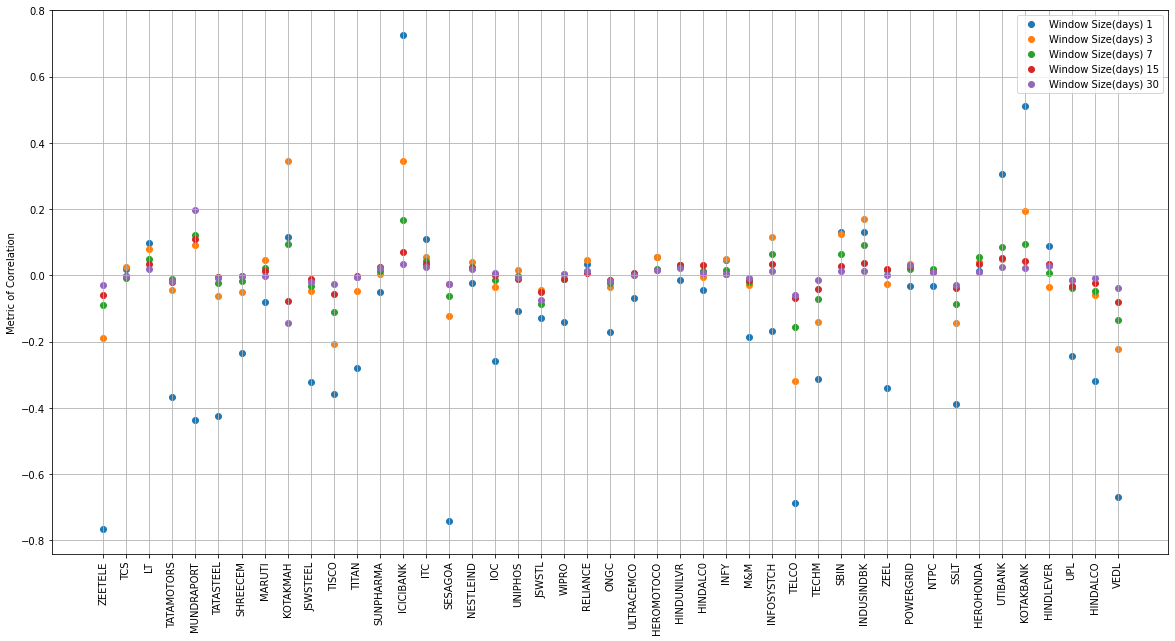

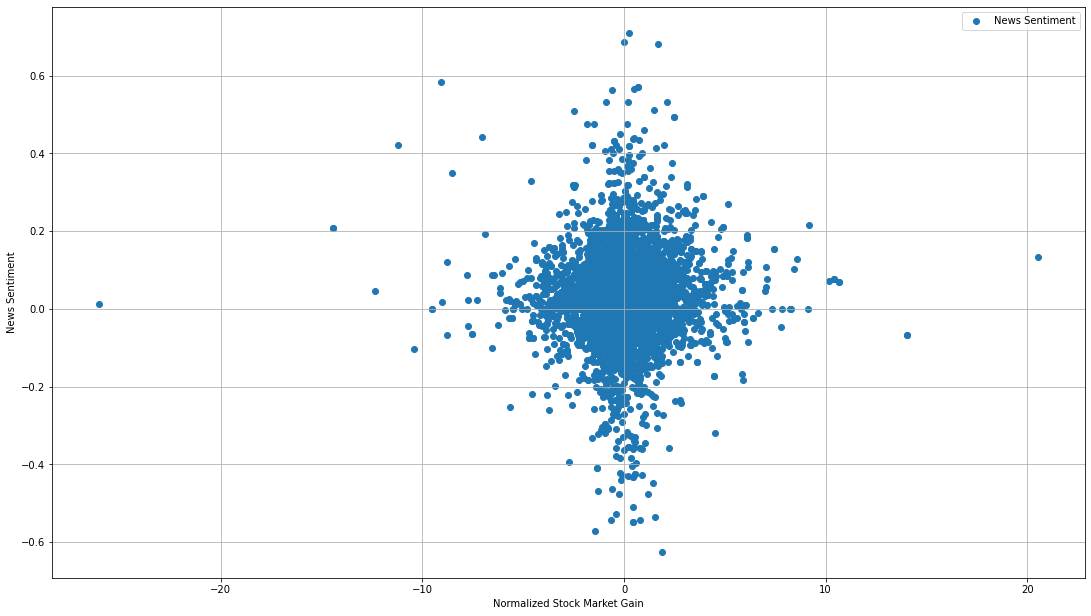

In [21]:
correlation_pd.sort_values(["avg(corelation)"])
sym = input('Symbol ')
filtered = correlation_pd[correlation_pd["Symbol"] == sym]
output_df = filtered.sort_values(["avg(corelation)"], ascending=True)["Symbol2"]#.tolist()
#print(filtered.sort_values(["avg(corelation)"], ascending=True))

print("Bottom 5 Correlated Stocks")
print(output_df.tolist()[0:5])

output_list = output_df.tolist()[-5:]
print("Top 5 Correlated Stocks")
print(output_df.tolist()[-5:][::-1])

print("Stock to News Sentiment Normalized Correlation Metric", stock_news_report_pdf[stock_news_report_pdf['Symbol']== sym]['AVG_PNS_Normalized'].tolist()[0])
# print("Stock to News Sentiment Average Correlation", stock_news_report_pdf[stock_news_report_pdf['Symbol']== sym]['AVG_PNS'].tolist()[0])

myfig,myax = plt.subplots(1,1, figsize=(20, 10))

legend = ["Window Size(days) 1"]
myax.scatter(filtered["Symbol2"], filtered["avg(corelation)"])
myax.set_xticklabels(filtered["Symbol2"], rotation=90)
for d in window_size:
  myax.scatter(filtered["Symbol2"], filtered["avg(corelation_"+str(d)+")"])
  legend.append("Window Size(days) "+str(d))
myax.set_ylabel("Metric of Correlation")
myax.legend(legend)
myax.grid()

myfig,myax = plt.subplots(1,1, figsize=(20, 20))
output_df = stock_news_df_pd[stock_news_df_pd['Symbol'] == sym]
myax.scatter(output_df['P_Delta'], output_df["News_Sentiment"])
myax.set_xlabel("Normalized Stock Market Gain")
myax.set_ylabel("News Sentiment")
myax.legend(["News Sentiment"])
myax.grid()

fig = plt.gcf()
#plt.grid()

fig.set_size_inches(18.5, 10.5)
